In [7]:
import pandas as pd
import numpy as np
from helper_functions import *

### Import Parameter Code Lists

In [8]:
# Import DMR Parameter Data
dmrs_2023 = read_dmr(2023, drop_no_limit=True)
unique_parameter_codes_dmrs = dmrs_2023['PARAMETER_CODE'].unique()
dmr_parameter_df = pd.read_csv('data/dmrs/REF_PARAMETER.csv')
dmr_parameter_df = dmr_parameter_df[dmr_parameter_df['PARAMETER_CODE'].isin(unique_parameter_codes_dmrs)]
print(f'{len(dmr_parameter_df)} parameters and {len(dmr_parameter_df["POLLUTANT_CODE"].unique())} unique pollutants in DMR limit and monitoring datasets')

# Import ESMR Data
esmr_data = read_esmr(save=False)
esmr_parameter_df = pd.DataFrame({'ESMR_PARAMETER_DESC': esmr_data['parameter'].unique()})

# Import IR Data
impaired_303d_2024 = pd.read_csv('data/ir/2024-303d.csv', skiprows=1)
ir_parameter_df = impaired_303d_2024[['Pollutant']].drop_duplicates().reset_index(drop=True)
ir_parameter_df.rename(columns={'Pollutant': 'IR_PARAMETER_DESC'}, inplace=True)

# Import CA toxics rule data
toxics_df = pd.read_csv('data/toxics/criteria_for_toxics.csv')

# Import CA toxics rule data
toxics_parameter_df = pd.read_csv('data/toxics/criteria_for_toxics.csv')
toxics_parameter_df = toxics_parameter_df.rename(columns={'Number compound': 'TOXICS_PARAMETER_DESC'})
toxics_parameter_df['TOXICS_PARAMETER_DESC'] = toxics_parameter_df['TOXICS_PARAMETER_DESC'].str.replace(r'^\d+\.\s*', '', regex=True)

2023 DMR data has 515451 DMR events and 421 unique permits
2023 DMR data has 53386 DMR events and 203 unique permits after filtering
200 parameters and 138 unique pollutants in DMR limit and monitoring datasets


/Users/dalywettermark/Documents/git/ca-sewersheds/helper_functions.py:152: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('processed_data/step1/esmr_data.csv')


### Find Parameters with Limits in CA based on DMR Dataset

In [9]:
dmr_parameter_df = categorize_parameters(dmr_parameter_df, parameter_sorting_dict, 'PARAMETER_DESC')
ir_parameter_df = categorize_parameters(ir_parameter_df, parameter_sorting_dict, 'IR_PARAMETER_DESC')
esmr_parameter_df = categorize_parameters(esmr_parameter_df, parameter_sorting_dict, 'ESMR_PARAMETER_DESC')
toxics_parameter_df = categorize_parameters(toxics_parameter_df, parameter_sorting_dict, 'TOXICS_PARAMETER_DESC')

# additional categorization of Total Toxics
mask = dmr_parameter_df['PARAMETER_CODE'].str.startswith(('T', 'W'))
dmr_parameter_df.loc[mask, 'PARENT_CATEGORY'] = 'Total Toxics'
dmr_parameter_df.loc[mask, 'SUB_CATEGORY'] = ''

# save ir_parameter_df
ir_parameter_df.to_csv('processed_data/step1/ir_parameter_df.csv', index=False)

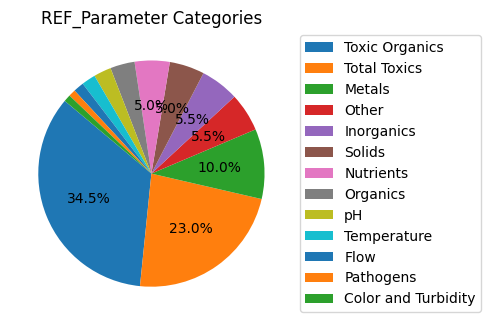

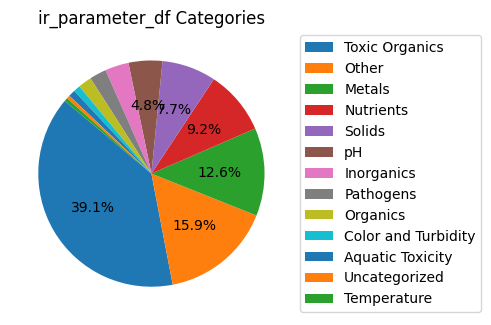

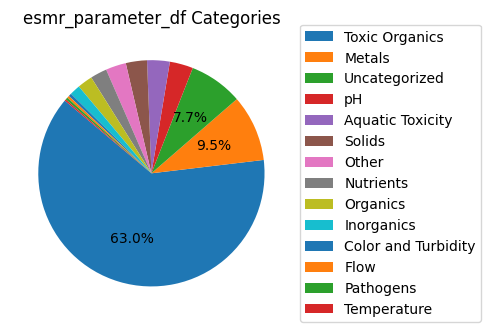

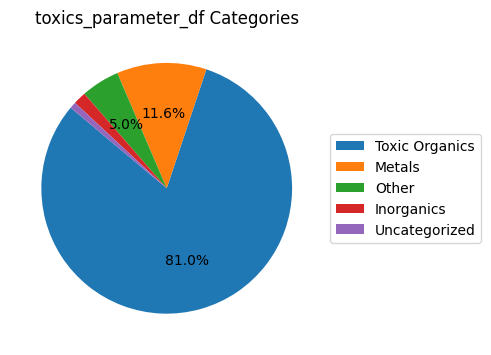

In [10]:
plot_pie_counts(dmr_parameter_df, 'REF_Parameter Categories')
plot_pie_counts(ir_parameter_df, 'ir_parameter_df Categories')
plot_pie_counts(esmr_parameter_df, 'esmr_parameter_df Categories')
plot_pie_counts(toxics_parameter_df, 'toxics_parameter_df Categories')

### Create list of parameter codes, names, and matched ESMR parameter names

In [11]:
# automatically match parameter names for ESMR and TOXICS
esmr_parameter_df['normalized_desc'] = esmr_parameter_df['ESMR_PARAMETER_DESC'].apply(normalize_param_desc)
toxics_parameter_df['normalized_desc'] = toxics_parameter_df['TOXICS_PARAMETER_DESC'].apply(normalize_param_desc)
dmr_parameter_df['ESMR_PARAMETER_DESC_MATCHED'] = dmr_parameter_df.apply(lambda row: match_parameter_desc(row, esmr_parameter_df, 'ESMR_PARAMETER_DESC'), axis=1)
dmr_parameter_df['TOXICS_PARAMETER_DESC'] = dmr_parameter_df.apply(lambda row: match_parameter_desc(row, toxics_parameter_df, 'TOXICS_PARAMETER_DESC'), axis=1)
print(f'{len(dmr_parameter_df["ESMR_PARAMETER_DESC_MATCHED"].unique()) - 1} out of {len(dmr_parameter_df)} parameter names automatically matched to ESMR PARAMETER_DESC')
print(f'{len(dmr_parameter_df["TOXICS_PARAMETER_DESC"].unique()) - 1} out of {len(dmr_parameter_df)} parameter names automatically matched to TOXICS_PARAMETER_DESC')


# add manual mappings
dmr_esmr_mapping_manual = pd.read_csv('processed_data/step1/dmr_esmr_mapping_manual.csv')
manual_mapping = dict(zip(dmr_esmr_mapping_manual['PARAMETER_CODE'], dmr_esmr_mapping_manual['ESMR_PARAMETER_DESC_MANUAL']))
dmr_parameter_df['ESMR_PARAMETER_DESC_MANUAL'] = dmr_parameter_df['PARAMETER_CODE'].map(manual_mapping).fillna('')

# combine automatic and manual mappings
dmr_parameter_df['ESMR_PARAMETER_DESC'] = dmr_parameter_df.apply(
        lambda row: row['ESMR_PARAMETER_DESC_MATCHED'] if row['ESMR_PARAMETER_DESC_MATCHED'] != '' 
        else (row['ESMR_PARAMETER_DESC_MANUAL'] if row['ESMR_PARAMETER_DESC_MANUAL'] != '' else 'No Match (unconfirmed)'),
        axis=1)

87 out of 200 parameter names automatically matched to ESMR PARAMETER_DESC
42 out of 200 parameter names automatically matched to TOXICS_PARAMETER_DESC
199 out of 200 parameter names manually mapped to ESMR PARAMETER_DESC in REF_PARAMETER.csv
199 out of 200 parameter names manually mapped to ESMR PARAMETER_DESC in REF_PARAMETER.csv


In [12]:
dmr_parameter_df.drop(columns=['ESMR_PARAMETER_DESC_MATCHED', 'ESMR_PARAMETER_DESC_MANUAL'], inplace=True)
dmr_parameter_df.rename(columns={'PARAMETER_DESC': 'DMR_PARAMETER_DESC'}, inplace=True)
dmr_parameter_df.to_csv('processed_data/step1/dmr_esmr_mapping.csv', index=False)